# 5G ENERGY CONSUMPTION MODEL - Estimating the energy consumption in a 5G Base Station

Network operational expenditure (OPEX) already accounts for around 25 percent of the total telecom operator’s cost, and 90 percent of it is spent on large energy bills. More than 70 percent of this energy is estimated to be consumed by the radio access network (RAN), particularly by the base stations (BSs).

#### Dataset
The dataset was provided by (International Telecommunication Union (ITU))[https://www.itu.int/en/Pages/default.aspx]. It has been derived from the original copy and simplified for learning purposes. It includes cell-level traffic statistics of 4G/5G sites collected on different days.

#### Objective & Goal
Thus, the objective is to build and train a ML model to *estimate the energy consumed* by different 5G base stations taking into consideration the impact of various *engineering configurations*, *traffic conditions*, and *energy-saving methods*.

#### Further Resources
To read more on the other objectives: (Read More)[https://challenge.aiforgood.itu.int/match/matchitem/83]

### Steps to follow
1. Import libraries
2. Load dataset
3. Data wrangling & exploration - statistical analysis, data cleaning, understanding, visualization, checking outliers etc
4. Choosing the model
5. Feature engineering & selection
6. Training model
7. Making predictions
8. Evaluation of the model
9. Improving the model

### Step 1: Importing Libraries

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

### Step 2: Loading & Exploring the dataset

In [2]:
energy_df = pd.read_csv('datasets/5G_energy_consumption_dataset.csv')
energy_df.head()

,Time,BS,Energy,load,ESMODE,TXpower
0,20230101 010000,B_0,64.275037,0.487936,0.0,7.101719
1,20230101 020000,B_0,55.904335,0.344468,0.0,7.101719
2,20230101 030000,B_0,57.698057,0.193766,0.0,7.101719
3,20230101 040000,B_0,55.156951,0.222383,0.0,7.101719
4,20230101 050000,B_0,56.053812,0.175436,0.0,7.101719


In [3]:
# Transforming the column names to lowercase
energy_df.columns = energy_df.columns.str.lower()

In [4]:
# Checking the shape
energy_df.shape

(92629, 6)

In [5]:
# General information of the data
energy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92629 entries, 0 to 92628
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   time     92629 non-null  object 
 1   bs       92629 non-null  object 
 2   energy   92629 non-null  float64
 3   load     92629 non-null  float64
 4   esmode   92629 non-null  float64
 5   txpower  92629 non-null  float64
dtypes: float64(4), object(2)
memory usage: 4.2+ MB


In [6]:
# Check for missing values
energy_df.isnull().sum()

time       0
bs         0
energy     0
load       0
esmode     0
txpower    0
dtype: int64

In [7]:
# Check for duplicates
energy_df.duplicated().sum()

np.int64(0)

In [8]:
energy_df.describe(include='all')

,time,bs,energy,load,esmode,txpower
count,92629,92629,92629.000000,92629.000000,92629.000000,92629.000000
unique,168,923,NaN,NaN,NaN,NaN
top,20230102 230000,B_583,NaN,NaN,NaN,NaN
freq,766,130,NaN,NaN,NaN,NaN
mean,NaN,NaN,28.138997,0.244705,0.081361,6.765427
std,NaN,NaN,13.934645,0.234677,0.382317,0.309929
min,NaN,NaN,0.747384,0.000000,0.000000,5.381166
25%,NaN,NaN,18.236173,0.057370,0.000000,6.427504
50%,NaN,NaN,24.065770,0.165550,0.000000,6.875934
75%,NaN,NaN,35.724963,0.363766,0.000000,6.875934


#### 2.1 High level report

1. There are 6 columns in the dataset made up of basic station information, cell-level data, energy consumption data including:
    - Time (Date and time in which the measurement was collected) - cell level and energy consumption
    - Bs(Name of base station) - basic station info.
    - Energy (Energy consumption measurement) - energy consumption data
    - Load (Load of the cell) - cell level data
    - Esmode (Intensity of the activation of different energy-saving modes. It takes value in [0-1]) - cell level data
    - Txpower (Maximum transmit power of the cell. It takes value in [0-1]) - basic station info.
  
2. The bs & time columns data types are all objects, for training our model we need to encode them.
3. There are 92629 rows in the datasets without any duplicates or missing values

#### 2.2 Generate ydata Profile Report

In [9]:
profile = ProfileReport(energy_df, title='5G Base Station Energy Consumption Report')

In [10]:
#profile.to_file(output_file='profile-report.html')

#### 2.3 Feature Engineering

#### 2.3.1 Transforming date type and splitting into the date and time columns

In [11]:
# Transforming time datatype
energy_df.time = pd.to_datetime(energy_df.time).astype('int64')/ 10**9
energy_df.time.dtype

dtype('float64')

In [43]:
energy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92629 entries, 0 to 92628
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   time     92629 non-null  float64
 1   bs       92629 non-null  object 
 2   energy   92629 non-null  float64
 3   load     92629 non-null  float64
 4   esmode   92629 non-null  float64
 5   txpower  92629 non-null  float64
dtypes: float64(5), object(1)
memory usage: 4.2+ MB


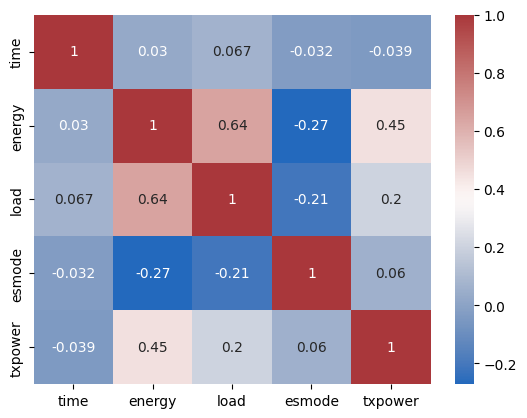

In [48]:
# Checking the correlation of the numerical columns in our data
numeric_df = energy_df.drop('bs', axis=1)
sns.heatmap(data = numeric_df.corr(), annot=True, cmap='vlag')
plt.show()

Basing on the correlation the load and txpower have a higher positive correlation to energy meaning an increase in load & txpower will increase the energy. The esmode has a negative correlation to energy meaning a decrease in the esmode will increase the energy output.

#### 2.3.2 Checking and handling outliers in the data

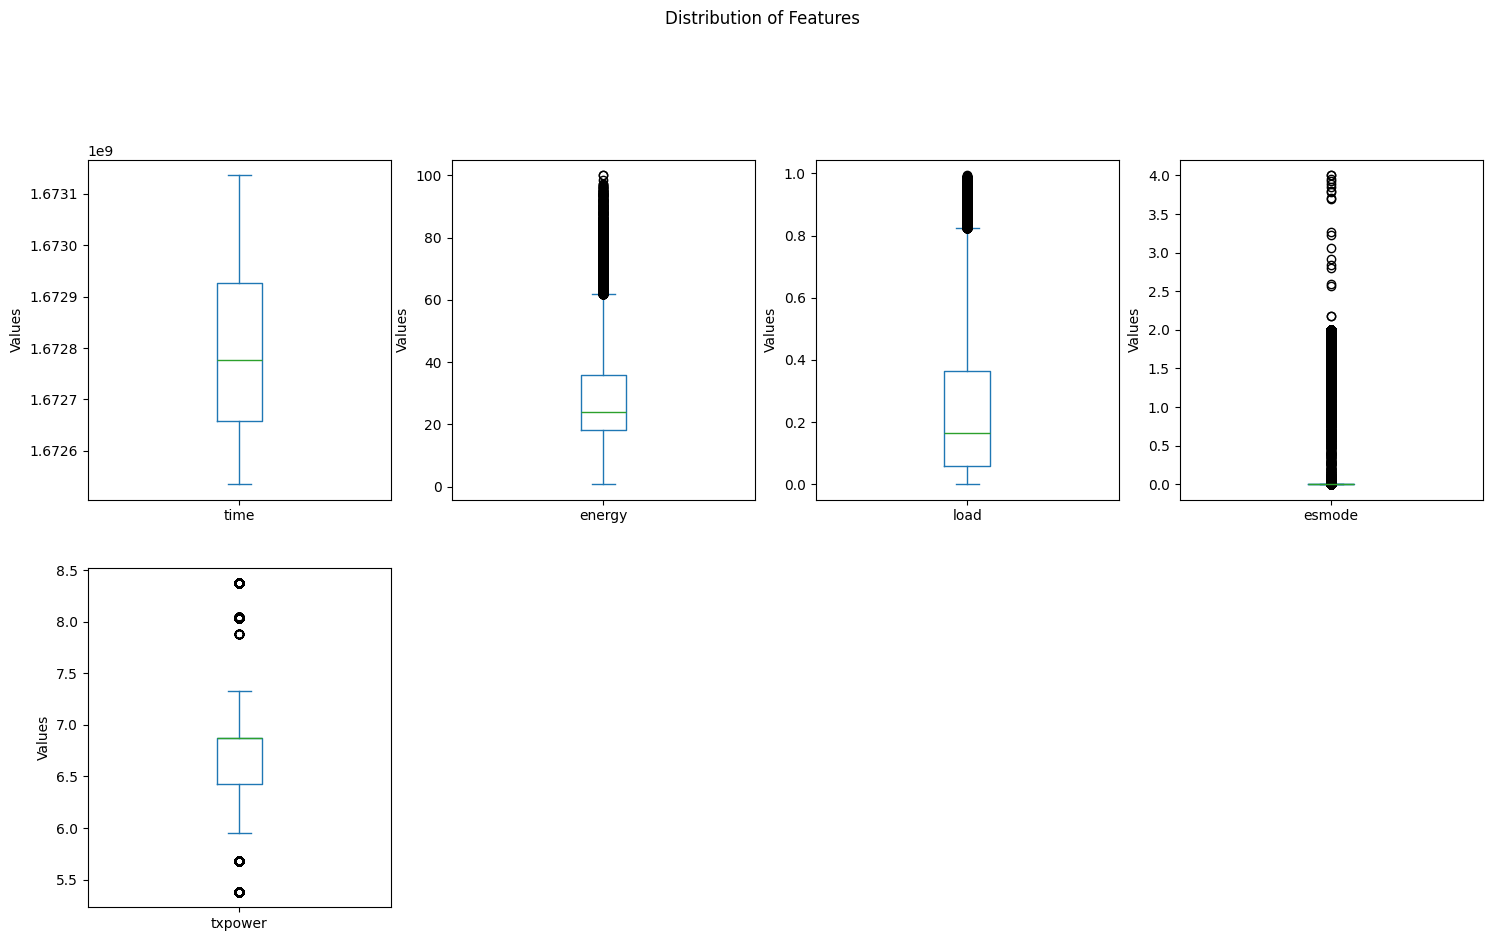

In [13]:
# Create a boxplot to see the distribution of data basing on the upper and lower percentiles
energy_df.plot(kind ='box', subplots=True, figsize=(18,15), layout =(3,4), ylabel='Values', title='Distribution of Features')
plt.show()

From the boxplot, the energy, load, esmode and txpower features have outliers that might make our model inaccurate. To handle the outliers, we'll use the IQR which subsets the data to within the lower (25th) and upper (75th) percentiles. This will reduce the influence of outliers when training our model later on

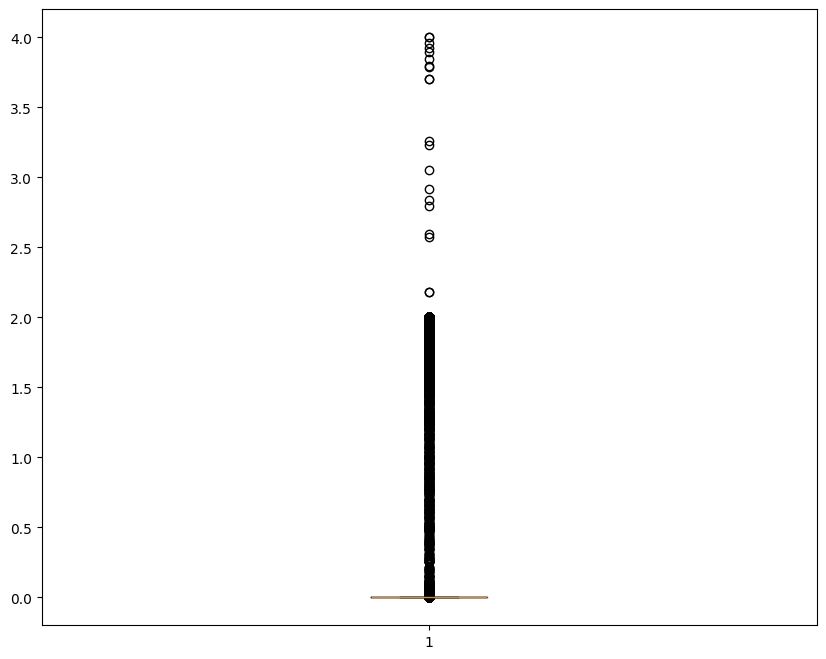

In [49]:
plt.figure(figsize=(10,8))
plt.boxplot(energy_df.esmode)
plt.show()

#### Use the Inter Quartile Range Approach to handle outliers

In [14]:
def outlier_limits(col):
    Q3, Q1 = np.nanpercentile(col, [75,25])
    inter_quartile_range = Q3 - Q1
    upper_limit = Q3 + (1.5*inter_quartile_range)
    lower_limit = Q1 - (1.5*inter_quartile_range)
    return upper_limit, lower_limit

In [15]:
outliers_energy_df = energy_df.copy()

In [16]:
outliers_energy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92629 entries, 0 to 92628
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   time     92629 non-null  float64
 1   bs       92629 non-null  object 
 2   energy   92629 non-null  float64
 3   load     92629 non-null  float64
 4   esmode   92629 non-null  float64
 5   txpower  92629 non-null  float64
dtypes: float64(5), object(1)
memory usage: 4.2+ MB


In [41]:
for col in outliers_energy_df.columns:
    if outliers_energy_df[col].dtype != 'object':
        UL, LL = outlier_limits(outliers_energy_df[col])
        outliers_energy_df[col] = np.where((outliers_energy_df[col] > UL) | (outliers_energy_df[col] < LL), np.nan, outliers_energy_df[col] ) #Where the numerical data is > upper limit and lower < lower limit, replace with null values

In [18]:
outliers_energy_df.isnull().sum()

time          0
bs            0
energy     2192
load       2974
esmode     5154
txpower    1169
dtype: int64

Handling the outliers through the IRA (inter quartile range) approach only retains data that's within the 25th (lower) and 75th (upper) quartiles.

#### 2.3.3 Encoding our categorical columns
According to the data, the categorical column: bs so we'll encode.

In [59]:
# Select only rows with values
df = outliers_energy_df[outliers_energy_df.notnull().all(axis=1)].copy()

In [60]:
df.isnull().sum()

time       0
bs         0
energy     0
load       0
esmode     0
txpower    0
dtype: int64

In [61]:
df.bs.nunique()

883

In [62]:
# Encode our bs column
le = LabelEncoder()
df.bs = le.fit_transform(df.bs)
df.bs.nunique()

883

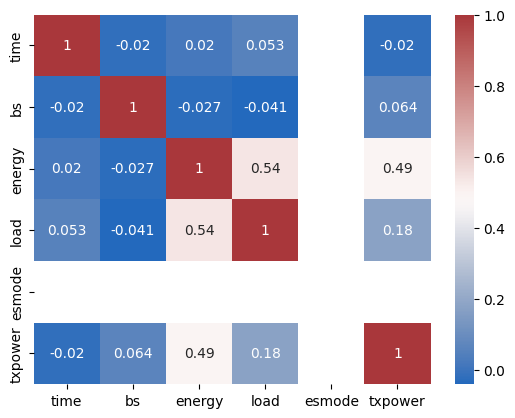

In [63]:
# Checking the correlation of the columns in our data
sns.heatmap(data = df.corr(), annot=True, cmap='vlag')
plt.show()

After removing the outliers, the features affecting energy positively are load and txpower which have only slightly reduced. The esmode basing on the IRA doesn't show any correlation given the values retained all are zero.

Given we need to estimate the energy consumed by the base stations considering the engineering configuraitons, traffic conditions & energy-savings methods, for our model we can drop the bs column as they'll generate unnecesary noise on our model.

Given the esmode doesn't have much correlation, we can also drop it.

Time only has a minimal positive correlation on the energy and hence we can drop it.

Therefore, we'll train our model basing on the load and txpower features with our target variable being energy

### Step 3: Training and making predictions on our model

Given we want to estimate the energy output, we'll make the energy column our target with the load and txpower as the features to formulate the prediction. The energy feature contains continuous values so we can use a Linear Regression Algorith. We'll also use a Random Forest Regression algorithm to test out how each model performs.

In [66]:
selected_df = df.drop(['bs', 'time', 'esmode'], axis = 1)
selected_df.head()

,energy,load,txpower
1,55.904335,0.344468,7.101719
2,57.698057,0.193766,7.101719
3,55.156951,0.222383,7.101719
4,56.053812,0.175436,7.101719
20,55.754858,0.210952,7.101719


In [67]:
# Select our features and target values
X = selected_df.drop('energy', axis=1)
y = selected_df.energy

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

#### 3.1 Linear Regression Algorithm

In [73]:
# Train our model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [78]:
model.intercept_

np.float64(-87.949483897994)

In [79]:
list(zip(X, model.coef_))

[('load', np.float64(27.808242747545375)),
 ('txpower', np.float64(16.1381848282959))]

In [80]:
# Make predictions
y_pred = model.predict(X_test)

#### 3.1.1 Evaluation our model performance

In [81]:
# Actual value vs predicted value
model_diff = pd.DataFrame({
    'Actual energy consumption' : y_test,
    'Predicted energy consumption': y_pred
})
model_diff.head(15)

,Actual energy consumption,Predicted energy consumption
76708,23.916293,29.419852
43520,12.855007,23.728895
42926,28.998505,19.155043
33844,17.189836,16.436146
35996,23.617339,25.664034
39118,45.291480,31.837664
64398,30.044843,22.677150
20098,39.162930,27.324742
58589,49.626308,30.190460
61777,17.937220,16.469516


In [82]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2score = r2_score(y_test, y_pred)

print('Mean Squared Error', mse)
print('Root Mean Squared Error', rmse)
print('R2 Score', r2score)

Mean Squared Error 68.09315126882296
Root Mean Squared Error 8.251857443559174
R2 Score 0.458010497033298


Basing on the evaluating metrics, the model isn't performing well. To improve it, I can: 

1. Introduce/remove some features. - feature selection
2. Standardize or normalize the data
3. Test out with another model

The goal will be to increase the r2 score to above 0.7 and lower the mean squared and root mean squared errors 

#### 3.2 Random Forest Regression Algorithm

Since random forest isn't susceptible to outliers and is best for handling null values, we can use our original data to test out the model predictions

In [90]:
energy_df.head()

,time,bs,energy,load,esmode,txpower
0,1.672535e+09,B_0,64.275037,0.487936,0.0,7.101719
1,1.672538e+09,B_0,55.904335,0.344468,0.0,7.101719
2,1.672542e+09,B_0,57.698057,0.193766,0.0,7.101719
3,1.672546e+09,B_0,55.156951,0.222383,0.0,7.101719
4,1.672549e+09,B_0,56.053812,0.175436,0.0,7.101719


In [92]:
rf_data = energy_df.copy()
rf_data = rf_data.drop(['bs','esmode','time'], axis=1)
rf_data.head(1)

,energy,load,txpower
0,64.275037,0.487936,7.101719


In [98]:
# Select our features and target values
X_rf = rf_data.drop('energy', axis=1)
y_rf = rf_data.energy

In [99]:
# Split our data
X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(X_rf, y_rf, test_size=0.3, random_state=42)

In [100]:
# out-of-bag (OOB) score, estimates the model’s generalization performance.
rf_model = RandomForestRegressor(n_estimators=10, random_state=42, oob_score=True)
rf_model.fit(X_rf,y_rf)

/Users/munge/.virtual-envs/ml-venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


RandomForestRegressor(n_estimators=10, oob_score=True, random_state=42)

In [101]:
# Access the OOB Score
oob_score = rf_model.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

Out-of-Bag Score: 0.7337162008517228


In [102]:
# Making predictions
y_rf_pred = rf_model.predict(X_rf_test)

In [104]:
# Actual value vs predicted value
rf_model_diff = pd.DataFrame({
    'Actual energy consumption' : y_rf_test,
    'Predicted energy consumption': y_rf_pred
})
rf_model_diff.head(15)

,Actual energy consumption,Predicted energy consumption
65601,44.843049,43.781764
2220,20.478326,16.122322
54370,13.751868,16.347285
80338,57.997010,60.209268
32751,37.967115,37.279522
30476,36.173393,35.635277
3737,56.053812,54.544096
88450,8.221226,8.221226
54297,12.107623,16.154050
81896,59.192825,58.744395


In [105]:
mse_rf = mean_squared_error(y_rf_test, y_rf_pred)
rmse_rf = np.sqrt(mse_rf)
r2score_rf = r2_score(y_rf_test, y_rf_pred)

print('Mean Squared Error', mse_rf)
print('Root Mean Squared Error', rmse_rf)
print('R2 Score', r2score_rf)

Mean Squared Error 9.390018511733047
Root Mean Squared Error 3.0643137097453073
R2 Score 0.9512760878781701


### Conclusion

In [107]:
# Comparison of r2 scores between the two models
model_comparison = pd.DataFrame({
    'Linear Regression' : [r2score],
    'Random Forest': [r2score_rf]
})
model_comparison.head()

,Linear Regression,Random Forest
0,0.45801,0.951276


Using the random forest algorithm to predict the energy greatly enhances the accuracy of the predictions. This is based on our R2 score which is greater than 0.7 and a lower mean squared error